In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch, torchvision
import torch.nn as nn

from torchvision.models import inception_v3
from PIL import Image
from IPython.display import clear_output
from torchvision import transforms as T
from tqdm.notebook import tqdm
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score

from torch.utils.data import Dataset, DataLoader

from IPython.display import clear_output
from copy import deepcopy
from gc import collect

In [2]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
PATH = '/kaggle/input/aaa-ml/avito-auto-moderation/'
TRAIN_FILE = 'train_v2.csv'
SUB_FILE = 'sample_submission_v2.csv'
IMAGE_SIZE = (299, 299)
MEAN = np.array([0.485, 0.456, 0.406])
STD = np.array([0.229, 0.224, 0.225])
DEVICE


device(type='cuda')

In [3]:
train = pd.read_csv(os.path.join(PATH, TRAIN_FILE))
submission = pd.read_csv(os.path.join(PATH, SUB_FILE))

In [4]:
np.random.seed(0)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Исправлю ошибки в разметке

In [5]:
# train.loc[118, 'label'] = 1
# train.loc[332, 'label'] = 1

# train.loc[332, 'label'] = 1  

train.loc[285, 'label'] = 0
train[train.image.isin(['925.jpg'])]

,image,label
285,925.jpg,0


In [6]:
train = train[train.image != '224.jpg']

In [7]:
train.label.mean()

0.14973730297723292

In [8]:
train.shape[0]

1142

In [9]:
submission.head()

,image,score
0,474.jpg,0.5
1,1052.jpg,0.5
2,63.jpg,0.5
3,1713.jpg,0.5
4,116.jpg,0.5


## Class examples

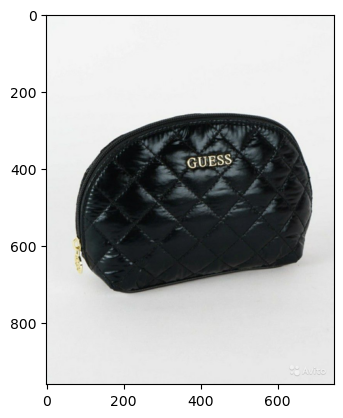

In [10]:
image_file = train.image[0]
img = plt.imread(os.path.join(PATH, image_file))
plt.imshow(img)

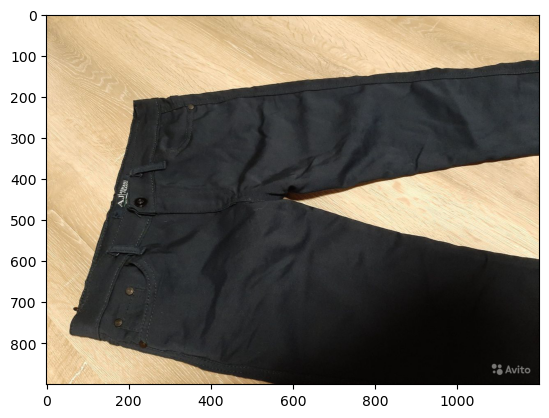

In [11]:
rand_idx = np.random.randint(0, train.shape[0])
image_file = train.image[rand_idx]
img = plt.imread(os.path.join(PATH, image_file))
plt.imshow(img)

In [12]:
submission.head()

,image,score
0,474.jpg,0.5
1,1052.jpg,0.5
2,63.jpg,0.5
3,1713.jpg,0.5
4,116.jpg,0.5


# Datasets

In [13]:
class AdvDataset(Dataset):
    def __init__(self, files, labels=None, augm=None):
        super().__init__()
        self.files = files
        self.augm = augm
        self.labels = labels
        self.transforms = T.Compose([
            T.Resize(IMAGE_SIZE),
            T.ToTensor(),
        ])
        self.norm = T.Normalize(MEAN, STD)
        
        # сложные для сети примеры, которым могут понадобиться допю веса
#         self.hard_exapmles = ['178.jpg', '251.jpg', '84.jpg', '391.jpg', '1584.jpg', '366.jpg']
        self.hard_examples = []
        
        self.images = [Image.open(os.path.join(PATH, file)) for file in files]  # загружаю в память для ускорения обучения
        if self.transforms is not None:
            self.images = [self.transforms(img) for img in self.images]
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        if self.labels is not None:  # режим обучения
            weight = 1
            if self.files[idx] in self.hard_examples:
                weight *= 2
            if self.augm is None:
                return self.norm(self.images[idx]), self.labels[idx], weight
            return self.norm(self.augm(self.images[idx])), self.labels[idx], weight
        return self.norm(self.images[idx])

In [14]:
# transforms
# augmentations
augm = T.Compose([
    T.RandomApply([
        T.RandomResizedCrop(
            IMAGE_SIZE, scale=(0.25, 1.0)
        )
    ], p=0.3),
    T.RandomApply([
        T.ColorJitter(brightness=(0.3, 1.3), 
                      contrast=(0.5, 1.3), 
                      saturation=(0.2, 1.2)
                     )
    ], p=0.5),    
    T.RandomApply([
        T.GaussianBlur(kernel_size=(9, 25), sigma=(0.1, 5)),
    ], p=0.5),
    T.RandomApply([
        T.RandomRotation(degrees=(0, 180))
    ], p=0.5),
])

In [15]:
def inv_transform(tensor):
    tensor_ = torch.transpose(tensor, 0, 2)
    tensor_ = tensor_ * STD + MEAN
    tensor_ = torch.transpose(tensor_, 0, 2)
    return tensor_

# Model

In [16]:
class Inception(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = inception_v3(pretrained=True)
        self.model.aux_logit = False
        
        self._set_requires_grad(self.model, False)
        self._set_requires_grad(self.model.Mixed_7c, True)
        self._set_requires_grad(self.model.Mixed_7b, True)
        
        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, 1)
        
    @staticmethod
    def _set_requires_grad(model, requires_grad=False):
        for param in model.parameters():
            param.requires_grad = requires_grad
    
    def forward(self, x):
        if self.model.training:
            return self.model(x).logits
        return self.model(x)
inception = Inception().to(DEVICE)

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

# Fit

In [17]:
%%time
TRAIN_SIZE = 0.5
BATCH_SIZE = 64
train_data, val_data = train_test_split(train, train_size=TRAIN_SIZE, random_state=42, stratify=train.label)

train_dataset = AdvDataset(
    files = train_data.image.values,
    labels = train_data.label.values,
    augm = augm
)

val_dataset = AdvDataset(
    files = val_data.image.values,
    labels = val_data.label.values,
    augm = None
)


test_dataset = AdvDataset(
    files = submission.image.values,
    augm = None
)

CPU times: user 23.6 s, sys: 1.68 s, total: 25.3 s
Wall time: 41 s


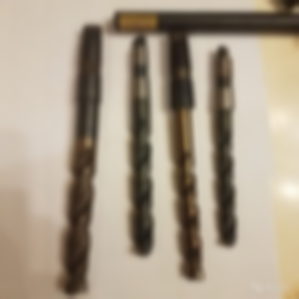

In [18]:
T.ToPILImage()(inv_transform(train_dataset[22][0]))

In [19]:
train_data.label.value_counts()

0    485
1     86
Name: label, dtype: int64

In [20]:
val_data.label.value_counts()

0    486
1     85
Name: label, dtype: int64

In [21]:
def plot_progress(train_losses, train_accs, val_losses, val_accs):
    clear_output(True)
    
    f, (ax1, ax3) = plt.subplots(nrows=1, ncols=2)
    f.set_figheight(6)
    f.set_figwidth(20)
    
    ax1.plot(train_losses, label='train loss')
    ax1.plot(val_losses, label='val loss')
    ax1.plot(np.zeros_like(train_losses), '--', label='zero')
    ax1.set_title('Loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Batch number')
    ax1.legend()
    
    
    ax3.plot(train_accs, label='train auc')
    ax3.plot(val_accs, label='val auc')
    ax3.plot(np.ones_like(train_accs), '--', label='100% auc')
    ax3.set_title('ROC-AUC')
    ax3.set_ylabel('ROC-AUC')
    ax3.set_xlabel('Batch epoch')
    ax3.legend()

    plt.show()

In [22]:
class EarlyStopper:
    def __init__(self,model, patience=1, min_delta=0):
        self.patience = patience
        self.max_delta = min_delta
        self.counter = 0
        self.max_validation_auc = -np.inf
        self.model = model
        self.state = deepcopy(model.state_dict())
        self.epoch = 0
        self.stop_epoch = 0
        self.train_probs, self.val_probs = [], []
        

    def early_stop(self, validation_auc, epoch, train_probs, val_probs):
        if validation_auc > self.max_validation_auc:
            self.max_validation_auc = validation_auc 
            self.state = deepcopy(self.model.state_dict())  # save model if improved
            self.model.stop = True
            self.train_probs = train_probs
            self.val_probs = val_probs
            self.counter = 0
            self.epoch = epoch
        elif validation_auc < (self.max_validation_auc - self.max_delta):
            self.counter += 1
            if self.counter >= self.patience:
                self.stop_epoch = epoch
                return True
        return False

In [23]:
def schedule(step_number, breaking_step1=40, breaking_step2=70):
    
    if step_number < breaking_step1:
        return step_number / breaking_step1
    elif step_number < breaking_step2:
        return 1
    else:
        return (0.99 ** (step_number - breaking_step2))

In [24]:
rng=np.random.RandomState(1234)

def get_ci_auc( y_true, y_pred ): 

#     from scipy.stats import sem
   
    n_bootstraps = 1000   
    bootstrapped_scores = []   
   
    for i in range(n_bootstraps):
        # bootstrap by sampling with replacement on the prediction indices
        indices = rng.randint(0, len(y_pred), len(y_pred))
       
        if len(np.unique(y_true[indices])) < 2:
            # We need at least one positive and one negative sample for ROC AUC
            # to be defined: reject the sample
            continue

        score = roc_auc_score(y_true[indices], y_pred[indices])
        bootstrapped_scores.append(score)   
 
    sorted_scores = np.array(bootstrapped_scores)
    sorted_scores.sort()

   # 90% c.i.
   # confidence_lower = sorted_scores[int(0.05 * len(sorted_scores))]
   # confidence_upper = sorted_scores[int(0.95 * len(sorted_scores))]
 
   # 95% c.i.
    confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
    confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
   
    return confidence_lower,confidence_upper, confidence_upper - confidence_lower

In [25]:
def fit(
    model,
    epochs=10,
    lr=0.001,
    batch_size=BATCH_SIZE,
    sched=False,
    smooth=False
):
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
    
    train_losses = []
    val_losses = []
    train_aucs = []
    val_aucs = []
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    if sched:
        scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, schedule)
        
    pos_weight = torch.tensor([1 / train_data.label.mean()])  # class-balancing weight
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(DEVICE), reduction='none')
    
    best_auc = 0.
    best_w = (model.state_dict())
    best_train_probs = []
    best_val_probs = []
    
    early_stopper = EarlyStopper(model, patience=2, min_delta=0.0001)
    clear_output(wait=True)
    for epoch in (range(epochs)):
        train_loss, train_auc = 0, 0
        probs = []
        model.train()
        for batch, labels, weights in train_loader:
            batch = batch.to(DEVICE)
            labels = labels.to(DEVICE)
            weights = weights.to(DEVICE)
            if smooth:
                smth = torch.from_numpy(np.random.uniform(0.0, 0.5, labels.shape[0])).to(DEVICE)
                labels = (1 - smth) * labels + smth / 2 
            
            output = model(batch)
            probs += torch.sigmoid(output).detach().cpu().tolist()
            loss = loss_fn(output.squeeze(1), labels.float())
            
            loss = torch.mean(weights * loss)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if sched:
                scheduler.step()
            
            train_loss += loss.item() / len(train_loader)

        train_auc = roc_auc_score(train_dataset.labels, probs)
            
        train_losses.append(train_loss)
        train_aucs.append(train_auc)
        
        model.eval()
        with torch.no_grad():
            val_loss, val_auc = 0, 0
            val_probs = []  # for rocauc calc
            for batch, labels, weights in val_loader:
                batch = batch.to(DEVICE)
                labels = labels.to(DEVICE)
                weights = weights.to(DEVICE)
                
                output = model(batch)
                val_probs += torch.sigmoid(output).detach().cpu().tolist()
                if smooth:
                    smth = torch.from_numpy(np.random.uniform(0.0, 0.5, labels.shape[0])).to(DEVICE)
                    labels = (1 - smth) * labels + smth / 2 
                loss = loss_fn(output.squeeze(1), labels.float())
                loss = torch.mean(weights * loss)
                val_loss += loss.item() / len(val_loader)

            val_auc = roc_auc_score(val_dataset.labels, val_probs)
            val_losses.append(val_loss)
            val_aucs.append(val_auc)
        
        if early_stopper.early_stop(val_auc, epoch, probs, val_probs):  # stop loop
            break  
    
        plot_progress(train_losses, train_aucs, val_losses, val_aucs)
    
    model.load_state_dict(early_stopper.state)
    torch.cuda.empty_cache()
    collect()
    return train_losses, train_aucs, val_losses, val_aucs, \
early_stopper.train_probs,early_stopper.val_probs, \
early_stopper.max_validation_auc, \
early_stopper.epoch, \
early_stopper.stop_epoch

# Fit

## Inception

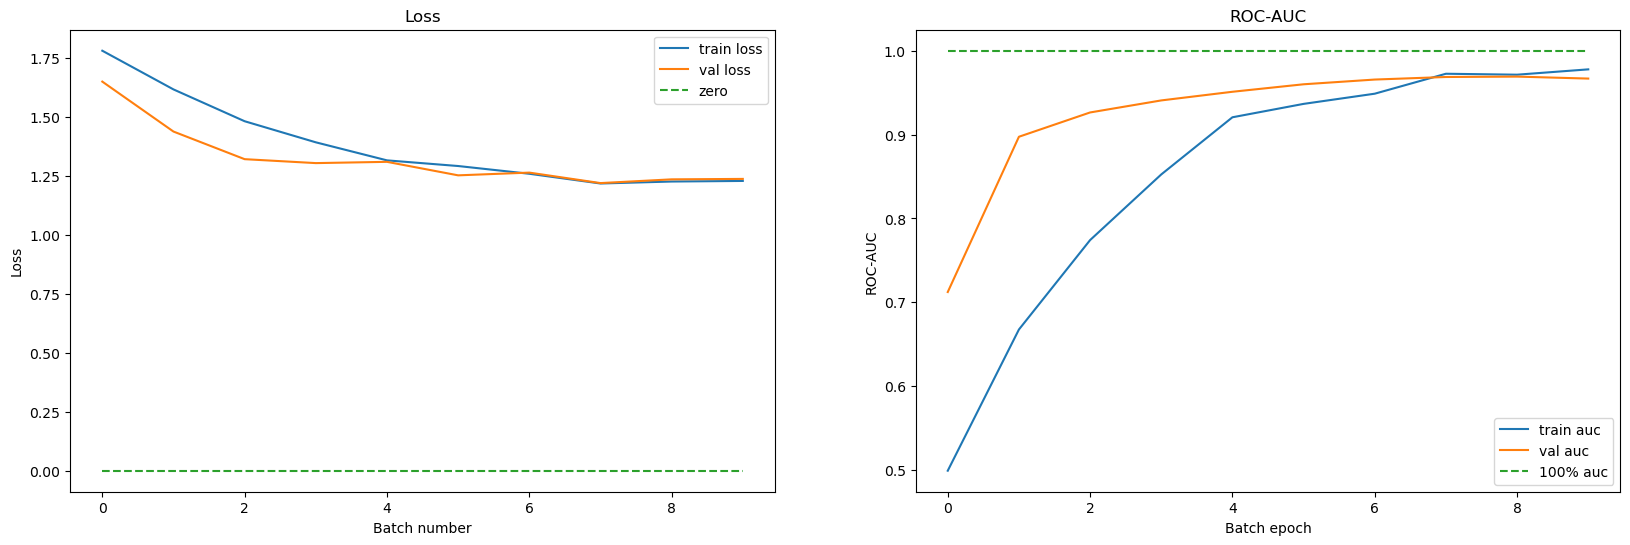

In [26]:
incpt_train_losses, incpt_train_aucs, incpt_val_losses, incpt_val_aucs, \
incpt_train_probs, incpt_val_probs, incpt_best_auc, incpt_best_epoch, incpt_stop_epoch = fit(
    inception,
    epochs=40,
    lr=0.0001,
    batch_size=BATCH_SIZE,
    sched=True,
    smooth=True
)  # убрал веса

In [27]:
print(
    f'ROC-AUC: {incpt_best_auc}, \
best epoch: {incpt_best_epoch}, stopped on {incpt_stop_epoch} epoch')

'ROC-AUC 95% CI: ({:.4f}, {:.4f}) | range: {:.3f}'.format(
    *get_ci_auc(np.array(val_dataset.labels), np.array(incpt_val_probs))
)

ROC-AUC: 0.9691358024691358, best epoch: 8, stopped on 10 epoch


'ROC-AUC 95% CI: (0.9536, 0.9804) | range: 0.027'

# Confidence

In [28]:
def plot_fp(probs, files, labels, top=10, kind='most'):
    f, axes = plt.subplots(nrows=top, figsize=(10,top*3))
    probs_zero = np.array(probs)[labels == 0].ravel()
    files_zero = np.array(files)[labels == 0].ravel()
    argsorted = np.argsort(probs_zero)
    if kind == 'most':
        argsorted = argsorted[::-1]
    plt.suptitle(f'{kind} confident')
    for i, ax in enumerate(axes):
        arg = argsorted[i]
        img = plt.imread(os.path.join(PATH, files_zero[arg]))
        ax.imshow(img)
        ax.set_title('{:.2f}: {}'.format(probs_zero[arg], files_zero[arg]))
        
def plot_fn(probs, files, labels, top=10, kind='most'):
    f, axes = plt.subplots(nrows=top, figsize=(10,top*3))
    probs_first = np.array(probs)[labels == 1].ravel()
    files_first = np.array(files)[labels == 1].ravel()
    argsorted = np.argsort(probs_first)
    if kind == 'most':
        argsorted = argsorted[::-1]
    plt.suptitle(f'{kind} confident')
    for i, ax in enumerate(axes):
        arg = argsorted[i]
        img = plt.imread(os.path.join(PATH, files_first[arg]))
        ax.imshow(img)
        ax.set_title('{:.2f}: {}'.format(probs_first[arg], files_first[arg]))

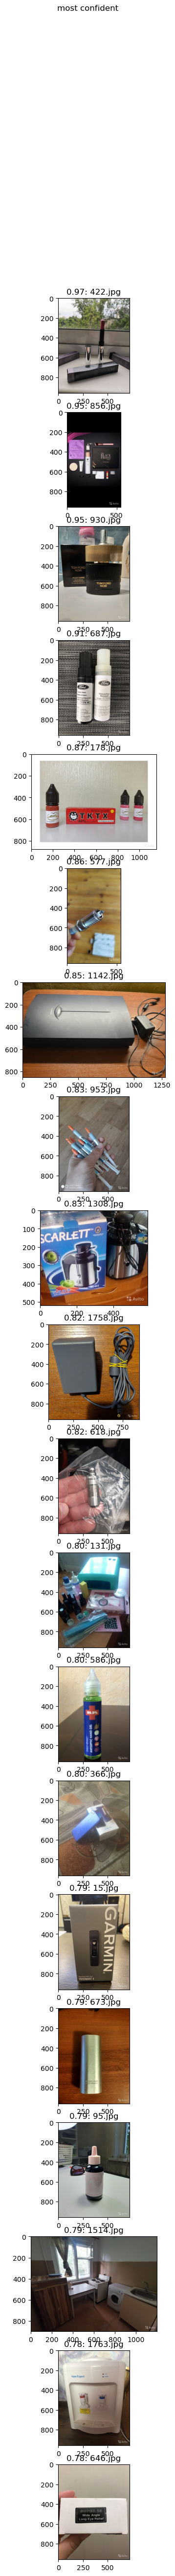

In [29]:
plot_fp(np.array(incpt_train_probs), list(train_dataset.files), train_dataset.labels, top=20, kind='most')

Можно заметить, что изображения 178 и 224 - это дубликаты, причем неверно размеченные (это жижа для вейпа - должна быть метка 1, а не 0, модель не ошиблась)

# Predict

## Inception

In [30]:
inception.eval()
probs = [torch.sigmoid(inception(test_dataset[i].to(DEVICE).unsqueeze(0))).item() for i in range(len(test_dataset))]
kaggle = pd.DataFrame({
    'image': test_dataset.files,
    'score': probs
})
kaggle

,image,score
0,474.jpg,0.976655
1,1052.jpg,0.375201
2,63.jpg,0.985829
3,1713.jpg,0.376264
4,116.jpg,0.688114
...,...,...
376,1735.jpg,0.629038
377,1382.jpg,0.415888
378,862.jpg,0.925039
379,1958.jpg,0.574078


In [31]:
kaggle.to_csv('/kaggle/working/inception.csv', index=False)